<a href="https://colab.research.google.com/github/AyushiNM/Transfer-Learning-Task-/blob/main/Transfer_Learning_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Downloading the dataset
! wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2020-10-22 08:29:57--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 172.217.7.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   177MB/s    in 0.4s    

2020-10-22 08:29:58 (177 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
!unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2117.

In [35]:
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [69]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

data_dir = '/content/cats_and_dogs_filtered/'

train_test_dir = os.path.join(data_dir, 'train/')
validation_dir = os.path.join(data_dir, 'validation/')

data = datasets.ImageFolder(train_test_dir, transform=data_transform)

train_data, test_data = torch.utils.data.random_split(data, [1000, 1000])
train_data, test_data = torch.utils.data.random_split(train_data, [750, 250])

valid_data = datasets.ImageFolder(validation_dir, transform=data_transform)
valid_data, _ = torch.utils.data.random_split(valid_data, [250, 750])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=10)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [88]:
print('Number of training images: ', len(train_data))
print('Number of test images: ', len(test_data))
print('Number of validation images: ', len(valid_data))

Number of training images:  750
Number of test images:  250
Number of validation images:  250


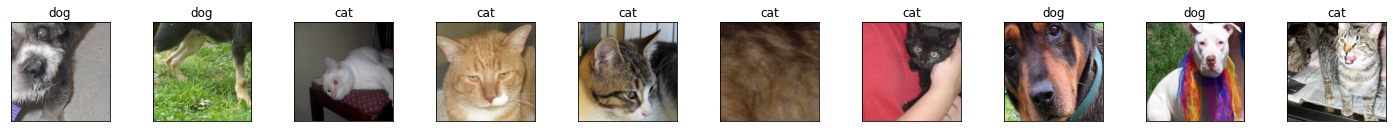

In [72]:
# Visualize some sample data
classes = ["cat", "dog"]
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [73]:
# Loading the pretrained vgg16 model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [74]:
# Freezing training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [75]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# checking to see if the last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)

2


In [76]:
import torch.optim as optim

# loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [77]:
n_epochs = 5

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0

    # model by default is set to train
    vgg16.train()
    for batch_i, (data, target) in enumerate(trainloader):

        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        

    vgg16.eval()
    for data, target in validloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
        
    # print training/validation loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.045030 	Validation Loss: 0.312082
Epoch: 2 	Training Loss: 0.030844 	Validation Loss: 0.290701
Epoch: 3 	Training Loss: 0.026687 	Validation Loss: 0.260057
Epoch: 4 	Training Loss: 0.025712 	Validation Loss: 0.227909
Epoch: 5 	Training Loss: 0.023871 	Validation Loss: 0.258859


In [78]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
batch_size = 10

vgg16.eval() # eval mode

# iterate over test data
for data, target in testloader:
  
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.212549

Test Accuracy of   cat: 92% (120/130)
Test Accuracy of   dog: 89% (107/120)

Test Accuracy (Overall): 90% (227/250)


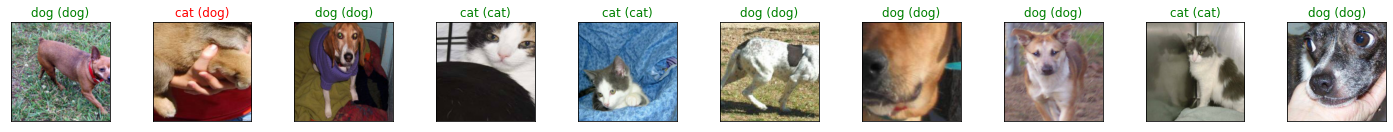

In [87]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# getting sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plotting the images in the batch, along with predicted and true labels
images = images.cpu()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))